# Lensed QSO work with Gaia DR2

Using the LQSO Castle match with DR2 as the learning set and apply this to LQSO allwise 2.

Trying with machine learning classification.

The idea is to use the following set of _features_ for each LQSO:

* the total proper motion and its error
* the total parallax and its error
* the astrometric colour
* the distance to the 3rd neighbour.

This makes 6 _features_ to feed to the classification.

Trying with two supervised classifications: `DecisionTree` and `RandomForest`. All Castle sources are `class=1`, randomly selecting 10000 from the QSO sample as `class=0`. The `RandomForest` method find much fewer candidates.


In [1]:
import os
import numpy as np

from astropy.table import Table, vstack

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.coordinates import SkyCoord 
import astropy.units as u

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree
from sklearn import tree as sktree
from sklearn.ensemble import RandomForestClassifier
#from IPython.display import Math
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import pandas as pd

#D2R = np.pi/180.0
# will use numpy functions deg2rad and rad2deg
home = os.path.expanduser('~')
wdir =  home + '/Dropbox/Work/Gaia-QSO'
dataDir = home + '/Dropbox/Work/Python/MIsc'

In [2]:
# read the Castle xmatch with DR2
#url1 = 'http://vospace.esac.esa.int/vospace/sh/9da5bd4b841f4032ee3f94e2f357067a554434?dl=1'
#t1 = Table.read(url1,format='votable')
file1 = '{}/lqso_castle-result.fits.gz'.format(dataDir)
t1 = Table.read(file1)
nt1 = len(t1)
#

In [3]:
# read the DR2 xmatch with allwise
#url2 = 'http://vospace.esac.esa.int/vospace/sh/d964d4b3687ede95d64c19609abb3136fbe55c0?dl=1'
#t2 = Table.read(url2,format='votable')
file2 = '{}/lqso_allwise2-result.fits.gz'.format(dataDir)
t2 = Table.read(file2)
nt2 = len(t2)
print (nt2)

495739


In [4]:
#t2.colnames
t2.rename_column('qso_id','qso_name')

In [5]:
t2['qso_name'] = t2['qso_name'].astype(t1['qso_name'].dtype)

In [6]:
#
# now add a column type, all from t1 will be type='LQSO' all from t2 are 'QSO'
t1['type'] = 'LQSO'
t2['type'] = 'QSO'

In [7]:
#
# merge the two tables
#
tx = vstack([t1,t2])

In [8]:
ix = np.where(~np.isnan(tx['astrometric_pseudo_colour']))[0]
tx = tx[ix]
print (len(ix))

490704


In [9]:
#
# now filter those with NaNs in the following columns
# 
m1 = np.isnan(tx['pmra'])
m2 = np.isnan(tx['pmdec'])
m3 = np.isnan(tx['parallax'])
ix = ~(m1 + m2 + m3)
print (len(np.where(ix)[0]))
#print (np.where(np.isnan(t['astrometric_pseudo_colour'])))
t = tx[ix]
nt = len(t)

490621


In [10]:
# the total pm
mu = np.sqrt(t['pmra']**2 + t['pmdec']**2)
# propagate the errors, assuming pmra_error and pmdec_errors are uncorrelated
mu_error = np.sqrt((t['pmra']*t['pmra_error']/mu)**2 + (t['pmdec']*t['pmdec_error']/mu)**2)
#
t['mu'] = mu
t['mu_error'] = mu_error
#
i_lqso = np.where(t['type'] == 'LQSO')[0]
n_lqso = len(i_lqso)
print ("Total number of LQSO is {}".format(n_lqso))
i_qso = np.where(t['type'] == 'QSO')[0]
n_qso = len(i_qso)
print ("Total number of QSO is {}".format(n_qso))

Total number of LQSO is 66
Total number of QSO is 490555


In [11]:
#
# convert ra,dec, from degrees to radians as this is needed for BallTree
#
ra_rad, dec_rad = map(np.deg2rad,[t['ra'],t['dec']])
#

In [12]:
#
# make a catalogue of Sky Coordinates, will need it later
#
catalog = SkyCoord(ra=t['ra'], dec=t['dec'], unit=u.degree)
#

In [13]:
#
# now calculate the nearest neighbour and the 3rd nearest neighbour to each source
# using BallTree
#
X = np.array([ra_rad,dec_rad]).transpose()
# metric haversine is the distance on a sphere
#nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree',metric='haversine').fit(X)
#distances, indices = nbrs.kneighbors(X)
tree = BallTree(X,leaf_size=30,metric="haversine")
distances, indices = tree.query(X,k=4,sort_results=True)

In [14]:
#
# add the distances to the nearest 3 neighbours in table
# convert from radians to arcsec
#
q1,q2,q3 = map(np.rad2deg,[distances[:,1],distances[:,2],distances[:,3]])
t["n1"] = 3600.0*q1
t["n1"].unit = u.arcsec
t["n2"] = 3600.0*q2
t["n2"].unit = u.arcsec
t["n3"] = 3600.0*q3
t["n3"].unit = u.arcsec

In [15]:
#df = t.to_pandas()

## Machine learning approach

Will try different methods to learn from the LQSO and apply it to the simulated catalogue


In [16]:
#X = np.array([t["mu"],t["mu_error"],t["parallax"],t["parallax_error"],\
#              t["n1"],t["n2"],t["n3"]]).transpose()
X = np.array([t["mu"],t["mu_error"],t["parallax"],t["parallax_error"],t["astrometric_pseudo_colour"],\
              t["n3"]]).transpose()
# transposed because the shape should be (n_samples, n_features)
y = np.zeros(nt,dtype=np.uint8)
y[i_lqso] = 1

(array([12., 37.,  6.,  9., 12.,  3., 10.,  2.,  6.,  7.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

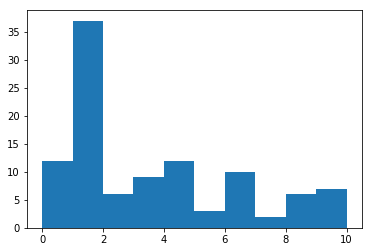

In [17]:
plt.hist(t['n3'],range=(0,10))

In [18]:
nr_qso = 1000
isub = np.hstack([i_lqso,np.random.choice(i_qso,size=nr_qso)])
Xp = X[isub,:]
yp = y[isub]
#clf = sktree.DecisionTreeClassifier()
clf = RandomForestClassifier()
clf.fit(Xp, yp)
#
ipred = np.where(clf.predict(X[i_qso,:]) == 1)[0]
tpred = t[i_qso[ipred]]
print ("potential LQSO: {} ({:.1f} %)".format(len(ipred),100*len(ipred)/n_qso))

potential LQSO: 3118 (0.6 %)


(array([ 6., 18.,  6.,  9., 12.,  3., 10.,  2.,  6.,  7.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

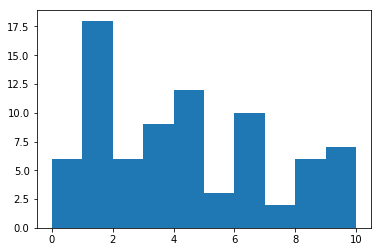

In [19]:
plt.hist(tpred['n3'],range=(0,10))

In [20]:
#
# now, keep only those with n3max less than xx arcsec
# 
rlimit = 10.0
ilimit = np.where(tpred['n3'].data <= rlimit)[0]
tout = tpred[ilimit]
print ("Total of {} candidates with max distance to 3rd neighbour less than {} arcsec".format(len(ilimit),rlimit))

Total of 79 candidates with max distance to 3rd neighbour less than 10.0 arcsec


In [35]:
#
# plotting functions from Alex, with some modifications
#
def getLQSO(catalog,center,r=10):
    #
    # catalog is SkyCoordinates object produced earlier
    # (ra_c,dec_c) is a list with ra and dec of the centre in degrees
    # r is the serach radius in arcsec, default 10"
    # 
    # return index array of the neighbours within r arcsec, same size as catalog
    #
    scalarc = SkyCoord(center['ra']*u.deg, center['dec']*u.deg)
    d2d = scalarc.separation(catalog)
    mmask = d2d.value < r/3600.0
    return np.where(mmask)[0]

def plotGaiaLense(full_cat,catalog,center,r=(-10,10),pm=True):
    indx = getLQSO(catalog,center)
    d = full_cat[indx].to_pandas()
    #d = getLQSO(dd,center)
    scale = u.arcsecond.to(u.deg)
    x = (d.ra-center['ra'])/scale/np.cos(np.deg2rad(center['dec']))
    y = (d.dec-center['dec'])/scale
    plt.errorbar(x,y,xerr=d.ra_error, yerr=d.dec_error,fmt='.')
    plt.scatter(x,y,s=100*np.exp(20-d.phot_g_mean_mag),c=d.astrometric_pseudo_colour)
    plt.colorbar()
    if pm : 
        vx = d.pmra
        vy = d.pmdec
        plt.quiver(x,y, vx, vy, angles='xy', scale_units='xy', scale=1)
        plt.errorbar(x+vx,y+vy,xerr=d.pmra_error, yerr=d.pmdec_error,fmt='o')
    plt.grid()
    plt.xlabel("gaia.ra - center.ra [\"]")
    plt.ylabel("gaia.dec - center.dec [\"]")
    #plt.title("Source_id: {}".format(center['source_id']))
    plt.title('RA: {:.7f}, Dec: {:.7f} (deg)'.format(center['ra'],center['dec']))
    plt.xlim(r)
    plt.ylim(r)

Index: 31, n1,n2,n3=1.6622792989927724,7.942869716312308,8.325952390586759 arcsec, 1 neighbours within 10 arcsec


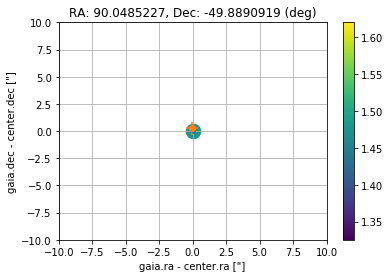

In [37]:
#iqqq = np.random.choice(len(ilimit))
iqqq = 31 # strange as the tree says 4 neighbours in 10 arcsec but the search says 1.
center = tout[iqqq]
iq = getLQSO(catalog,center)
print ("Index: {}, n1,n2,n3={},{},{} arcsec, {} neighbours within 10 arcsec".format(iqqq,tout['n1'][iqqq], tout['n2'][iqqq], tout['n3'][iqqq],len(iq)))
#
plotGaiaLense(t,catalog,center,r=(-10,10))